# Tarea 12. Algorítmos "genéticos" 

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.constants as cte
from scipy.integrate import quad
import pandas as pd

# Importamos libreria de algoritmos evolutivos 

from deap import base, creator, tools, algorithms

# importamos modulo independiente para acoplar a DEAP, adjunto en la carpeta fuente. 

import elitism

# We import an independent module to implement elitism in the GA.

import random

In [9]:
#tex PREAMBLE

from matplotlib import animation, rc
#from IPython.display import HTML
#%matplotlib inline
#sb.set()
#******************************************************

#rc('font',**{'family':'serif','serif':['Times']})
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)

#LaTeX
plt.rc('text', usetex=True)
plt.rc('font', family='serif')


Importamos los datos de cronometros cósmicos

In [10]:
data_cc = np.loadtxt('cosmic_clocks_2022_nomethod.csv',delimiter=',',dtype=float, skiprows=1)
data1= pd.DataFrame(data_cc, columns=['z','Hz','error_Hz'])

In [11]:
z_obs = data_cc[:,0]
Hz = data_cc[:,1]
dHz = data_cc[:,2]

In [12]:
# Ecuación de Friedmann para w(z) de CPL (visto en tarea 9)
def Hz_CPL(z,w_0,w_a):

    # Usando datos de Planck 2018: 
    # Tabla 2: TT,TE,EE+lowE+lensing+BAO
    
    #OmR = 1e-4 
    #OmK = -0.01
    OmDE = 0.6889
    OmM = 0.3111
    H0 = 67.66               
    
    #Hz = H0*np.sqrt(OmR*(1+z)**4+OmM*(1+z)**3 + OmK*(1+z)**2 + OmDE*(1+z)**(3*(w_0+w_a+1)*np.exp(-3*w_a*z/1+z)))
    Hz = H0*np.sqrt(OmM*(1+z)**3 + OmDE*(1+z)**(3*(w_0+w_a+1)*np.exp(-3*w_a*z/1+z)))
    return Hz

In [13]:
# # We define the marginalized Chi-Square.

def X(w_0, w_a):
    H_model = np.array([Hz_CPL(z,w_0,w_a) for z in z_obs])
    X_vec = np.power(((H_model - Hz) / dHz), 2)
    return X_vec.sum()

def Y(w_0, w_a):
    H_model = np.array([Hz_CPL(z,w_0,w_a) for z in z_obs])
    Y_vec = (H_model - Hz) / dHz**2
    return Y_vec.sum()

def Z(w_0, w_a):
    H_model = np.array([Hz_CPL(z,w_0,w_a) for z in z_obs])
    Z_vec = 1.0/dHz**2
    return Z_vec.sum()

def chisq(individual):
    w_0=individual[0]
    w_a=individual[1]
    
    m_model = np.array([Hz_CPL(z,w_0,w_a) for z in z_obs])
    chisq_vec = X(w_0, w_a) - Y(w_0, w_a)**2/Z(w_0, w_a) + np.log10(Z(w_0, w_a)/2*np.pi)
    f=chisq_vec.sum()
    return f,

In [14]:
# problem constants:
DIMENSIONS = 2  # number of dimensions
BOUND_LOW, BOUND_UP = -1.2, 0.0  # boundaries for all dimensions
#BOUND_LOW, BOUND_UP = -1, -0.05  # boundaries for all dimensions
#BOUND_LOW, BOUND_UP = -2.0, -0.05  # boundaries for all dimensions



# Genetic Algorithm constants:
POPULATION_SIZE = 20  # 10-20
P_CROSSOVER = 0.7  # probability for crossover
P_MUTATION = 0.3   # (try also 0.5) probability for mutating an individual
MAX_GENERATIONS = 20  # 100- 300
HALL_OF_FAME_SIZE = 1
CROWDING_FACTOR = 20.0  # crowding factor for crossover and mutation

# set the random seed:
RANDOM_SEED = 555
random.seed(RANDOM_SEED)

In [15]:
toolbox = base.Toolbox()

In [16]:
# define a single objective, minimizing fitness strategy:
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))

# create the Individual class based on list:
creator.create("Individual", list, fitness=creator.FitnessMin)

# helper function for creating random real numbers uniformly distributed within a given range [low, up]
# it assumes that the range is the same for every dimension
def randomFloat(low, up):
    return [random.uniform(l, u) for l, u in zip([low] * DIMENSIONS, [up] * DIMENSIONS)]

# create an operator that randomly returns a float in the desired range and dimension:
toolbox.register("attrFloat", randomFloat, BOUND_LOW, BOUND_UP)

# create the individual operator to fill up an Individual instance:
toolbox.register("individualCreator", tools.initIterate, creator.Individual, toolbox.attrFloat)

# create the population operator to generate a list of individuals:
toolbox.register("populationCreator", tools.initRepeat, list, toolbox.individualCreator)

In [17]:
toolbox.register("evaluate", chisq)

In [18]:
# genetic operators:
toolbox.register("select", tools.selTournament, tournsize=2)
toolbox.register("mate", tools.cxSimulatedBinaryBounded, low=BOUND_LOW, up=BOUND_UP, eta=CROWDING_FACTOR)
toolbox.register("mutate", tools.mutPolynomialBounded, low=BOUND_LOW, up=BOUND_UP, 
                 eta=CROWDING_FACTOR, indpb=1.0/DIMENSIONS)

In [19]:
# Genetic Algorithm flow:
def main():

    # create initial population (generation 0):
    population = toolbox.populationCreator(n=POPULATION_SIZE)

    # prepare the statistics object:
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("min", np.min)
    stats.register("avg", np.mean)

    # define the hall-of-fame object:
    hof = tools.HallOfFame(HALL_OF_FAME_SIZE)

    # perform the Genetic Algorithm flow with elitism:
    population, logbook = elitism.eaSimpleWithElitism(population, toolbox, cxpb=P_CROSSOVER, mutpb=P_MUTATION,
                                              ngen=MAX_GENERATIONS, stats=stats, halloffame=hof, verbose=True)

    # print info for best solution found:
    best = hof.items[0]
    print("-- Best Individual = ", best)
    print("-- Best Fitness = ", best.fitness.values[0])

    print("chisq / dof = ", best.fitness.values[0] / (len(z_obs) - 1))


    print("- Best solutions are:")
    for i in range(HALL_OF_FAME_SIZE):
        print(i, ": ", hof.items[i].fitness.values[0], " -> ", hof.items[i])

    # extract statistics:
    # minFitnessValues, meanFitnessValues = logbook.select("min", "avg")
    gen, avg, min_, max_ = logbook.select("gen", "avg", "min", "max")

    return population, logbook, hof

/tmp/ipykernel_6975/3573561725.py:14: RuntimeWarning: overflow encountered in double_scalars
  Hz = H0*np.sqrt(OmM*(1+z)**3 + OmDE*(1+z)**(3*(w_0+w_a+1)*np.exp(-3*w_a*z/1+z)))
/tmp/ipykernel_6975/282962505.py:23: RuntimeWarning: invalid value encountered in double_scalars
  chisq_vec = X(w_0, w_a) - Y(w_0, w_a)**2/Z(w_0, w_a) + np.log10(Z(w_0, w_a)/2*np.pi)


gen	nevals	min	avg
0  	20    	nan	nan
1  	14    	nan	nan
2  	17    	47.8424	62.6286
3  	15    	47.8424	61.5753
4  	16    	47.8424	61.0195
5  	14    	47.8424	61.3784
6  	11    	38.3593	58.5373
7  	13    	32.1657	55.1341
8  	15    	32.1657	2.05807e+15
9  	16    	28.6449	4.09894e+18
10 	12    	28.6449	38.9772    
11 	14    	28.5717	29127.7    
12 	14    	28.5467	33.876     
13 	15    	28.5467	40.1474    
14 	17    	28.5467	3.35417e+29
15 	17    	28.5467	5.78748e+08
16 	15    	28.5467	1.41674e+22
17 	13    	28.5467	1.47208e+07
18 	11    	28.5467	1.45235e+08
19 	15    	28.5462	4.0873e+23 
20 	14    	28.5462	7.11039e+06
-- Best Individual =  [-0.6994009912828976, -0.3091714589876881]
-- Best Fitness =  28.54622510520746
chisq / dof =  0.5709245021041491
- Best solutions are:
0 :  28.54622510520746  ->  [-0.6994009912828976, -0.3091714589876881]


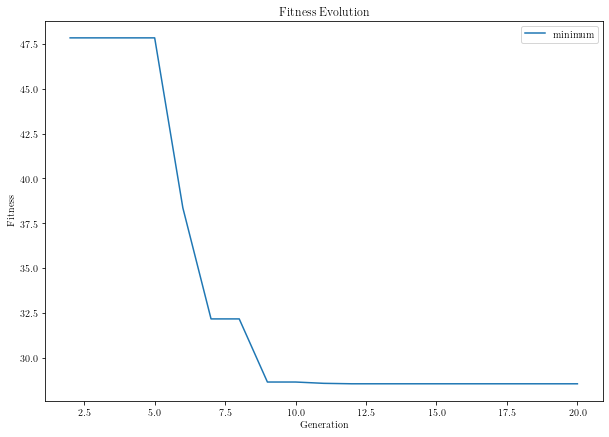

In [20]:
pop, log, hof = main()

gen, avg, min_, max_ = log.select("gen", "avg", "min", "max")

plt.figure(figsize=(10, 7))
#plt.plot(gen, avg, label="average")
plt.plot(gen, min_, label="minimum")
#plt.plot(gen, max_, label="maximum")
plt.title("Fitness Evolution")
plt.xlabel("Generation")
plt.ylabel("Fitness")
plt.legend(loc="upper right")
#plt.savefig('GA_wwCDM_150.png')
plt.show()

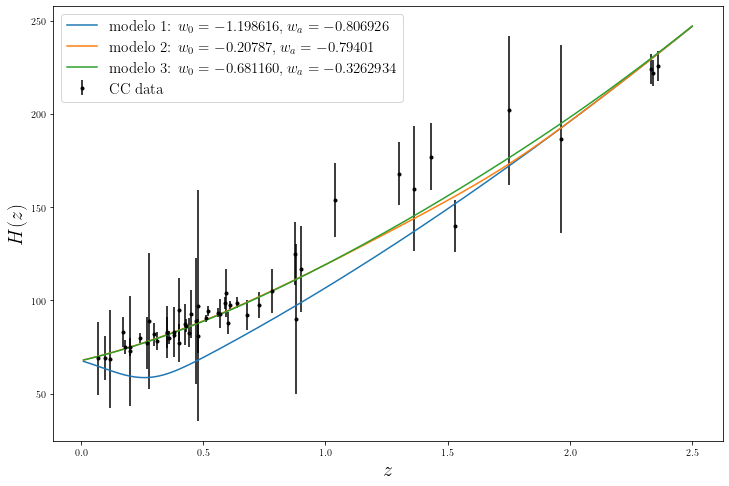

In [26]:
# Plots
zs = np.arange(0.01, 2.5, 0.01)
Hzbest1=np.vectorize(lambda z: Hz_CPL(z,-1.198616,-0.806926))
Hzbest2=np.vectorize(lambda z: Hz_CPL(z,-0.20787,-0.79401))
Hzbest3=np.vectorize(lambda z: Hz_CPL(z,-0.681160,-0.3262934))


plt.figure(figsize=(12, 8))
plt.xlabel('$z$',  fontsize=20)
plt.ylabel('$H(z)$',fontsize=20)
plt.plot(zs, Hzbest1(zs), label="modelo 1: $w_0=-1.198616, w_a=-0.806926$")
plt.plot(zs, Hzbest2(zs), label="modelo 2: $w_0=-0.20787, w_a=-0.79401$")
plt.plot(zs, Hzbest3(zs), label="modelo 3: $w_0=-0.681160, w_a=-0.3262934$")
plt.errorbar(z_obs, Hz, dHz, fmt='k.', label=r"CC data")
plt.legend(fontsize=15);
plt.show()
#plt.savefig('resultado_1.png')

### Importante!

Notemos que los valores de $w_0$ y $w_a$ dependen fuertemente de la elección de límites para la exploración, por ejemplo, los límites de los modelos 1, 2 y 3, respectivamente, fueron:

- BOUND_LOW, BOUND_UP = -1.2, 0.0  
- BOUND_LOW, BOUND_UP = -1, -0.05  
- BOUND_LOW, BOUND_UP = -2.0, -0.05

Y notemos cómo cambia el resultado. También pude observar que el cambio en el RANDOM SEED generaba un cambio en los resultados, incluso dejando todo fijo excepto la semilla.